# MURA Reproduction Notebook

This notebook reproduces the work from the paper **"Hidden Stratification Causes Clinically Meaningful Failures in Machine Learning for Medical Imaging"** using the MURA dataset.

## Objectives:
- Explore the MURA dataset
- Reproduce the original classification models
- Investigate hidden stratification issues
- Evaluate model performance
- Analyze subgroup accuracy and potential failures

All code cells have been cleaned and annotated for clarity.


In [1]:
import os
from glob import glob
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import torch.nn as nn
import torchvision.models as models
from torch.optim import Adam
from torch.cuda.amp import autocast, GradScaler

In [2]:
# -------------------------------
# Load MURA Dataset: train or valid folder
# -------------------------------
def load_mura_dataframe(data_dir):
    rows = []
    for root, dirs, files in os.walk(data_dir):
        for d in dirs:
            if d.endswith("_positive") or d.endswith("_negative"):
                label = 1 if d.endswith("_positive") else 0
                study_path = os.path.join(root, d)
                for img_file in glob(os.path.join(study_path, '*.png')):
                    rows.append((img_file, label))
    return pd.DataFrame(rows, columns=["image_path", "label"])

# -------------------------------
# Define PyTorch Dataset
# -------------------------------
class MURADataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "image_path"]
        label = self.df.loc[idx, "label"]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# -------------------------------
# Image Transforms (using ImageNet stats)
# -------------------------------
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

# -------------------------------
# Load and split data
# -------------------------------
# Path to your folders
train_dir = r"D:\Downloads\muramskxrays\MURA-v1.1\MURA-v1.1\train"
test_dir = r"D:\Downloads\muramskxrays\MURA-v1.1\MURA-v1.1\valid"

# Load full training and testing dataframes
full_train_df = load_mura_dataframe(train_dir)
test_df = load_mura_dataframe(test_dir)

# Split full training set into train + val
train_df, val_df = train_test_split(
    full_train_df,
    test_size=0.1,
    stratify=full_train_df['label'],
    random_state=42
)

print(f"Train set: {len(train_df)} samples | Abnormal: {train_df['label'].sum()}")
print(f"Val set:   {len(val_df)} samples | Abnormal: {val_df['label'].sum()}")
print(f"Test set:  {len(test_df)} samples | Abnormal: {test_df['label'].sum()}")

# -------------------------------
# Create Dataset and DataLoaders
# -------------------------------
train_dataset = MURADataset(train_df, transform=image_transform)
val_dataset = MURADataset(val_df, transform=image_transform)
test_dataset = MURADataset(test_df, transform=image_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

Train set: 33127 samples | Abnormal: 13386
Val set:   3681 samples | Abnormal: 1487
Test set:  3197 samples | Abnormal: 1530


Labels: ['Normal', 'Abnormal', 'Normal', 'Abnormal', 'Normal', 'Abnormal', 'Normal', 'Abnormal']


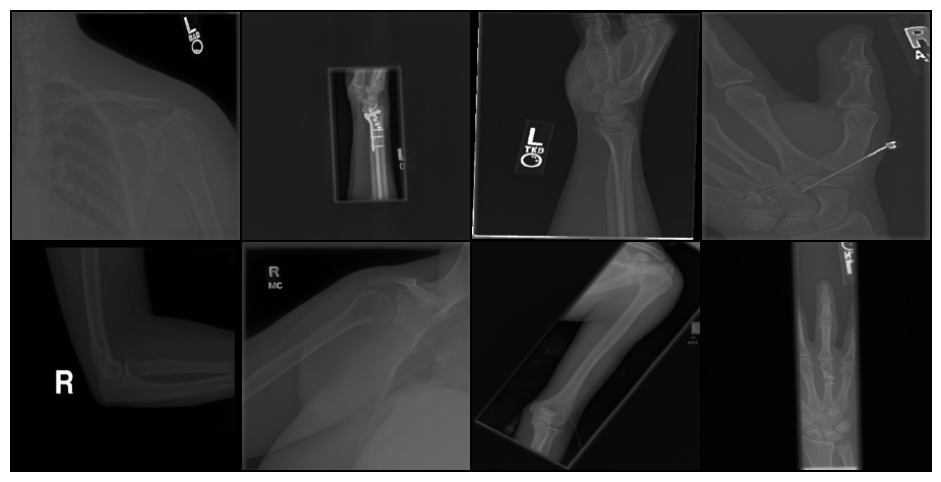

In [3]:
def show_images_from_loader(dataloader, class_names={0: "Normal", 1: "Abnormal"}):
    # Get one batch
    images, labels = next(iter(dataloader))

    # Unnormalize (ImageNet mean/std)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    images = images * std + mean  # undo normalization

    # Show a grid of images
    grid_img = torchvision.utils.make_grid(images[:8], nrow=4)
    plt.figure(figsize=(12, 6))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")
    titles = [class_names[int(l)] for l in labels[:8]]
    print("Labels:", titles)
    plt.show()
show_images_from_loader(train_loader)

In [4]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained DenseNet-169
model = models.densenet169(pretrained=True)

# Replace classifier with binary classifier
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 1)  # Output = 1 logit for binary classification

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

scaler = GradScaler()

def train_one_epoch(model, dataloader, optimizer, criterion, scaler):
    model.train()
    total_loss = 0
    loop = tqdm(dataloader, desc="Training", leave=False)

    for images, labels in loop:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()

        with autocast():  # AMP context
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * images.size(0)
        loop.set_postfix(loss=loss.item())

    return total_loss / len(dataloader.dataset)


def evaluate(model, dataloader):
    model.eval()
    preds = []
    targets = []
    loop = tqdm(dataloader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for images, labels in loop:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs).squeeze()

            preds.extend(probs.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    auc = roc_auc_score(targets, preds)
    return auc

C:\Users\wangh\anaconda3\envs\mura-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\wangh\anaconda3\envs\mura-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\wangh\AppData\Local\Temp\ipykernel_13456\96770421.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [5]:
n_epochs = 2

for epoch in range(n_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
    val_auc = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Val AUC: {val_auc:.4f}")

Training:   0%|                                                                                | 0/518 [00:00<?, ?it/s]C:\Users\wangh\AppData\Local\Temp\ipykernel_13456\96770421.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # AMP context


Epoch 1/2 | Train Loss: 0.4685 | Val AUC: 0.8668


Training:   0%|                                                                                | 0/518 [00:00<?, ?it/s]C:\Users\wangh\AppData\Local\Temp\ipykernel_13456\96770421.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # AMP context
                                                                                                                       

Epoch 2/2 | Train Loss: 0.3858 | Val AUC: 0.8790


In [6]:
evaluate(model, test_loader)

0.8778950092334473